In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import matplotlib.patches as mpatches
import dask
from scipy.ndimage import gaussian_filter

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import tools_plotting as to_plot

In [3]:
from open_experiment import control_deaccu,control_land, control_sfc, fixedSM_sfc, fixedSM_land, fixedSM_deaccu

In [4]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [5]:
path='/scratch/wcq7pz/exp_levante_post/'
## open topography, land_fraction
topo5km = xr.open_dataset(path+'topography_dom03_5km.nc')
topo5km.coords['lon'] = (topo5km.coords['lon'] + 180) % 360 - 180
topo5km  = topo5km.sortby(topo5km.lon)

frland=xr.open_dataset(path+'fr_land_dom03_5km.nc')
frland.coords['lon'] = (frland.coords['lon'] + 180) % 360 - 180
frland = frland.sortby(frland.lon)

In [6]:
## READ AMAZON BORDER AND MASK
df2 = pd.read_csv('coords_ab.txt', sep='\s+', header=None)
amaz2 = df2.apply(pd.to_numeric, args=('coerce',)).values

onlyab = xr.open_dataset('onlyab5km.nc')
maskAB = onlyab.interp(lat = topo5km.lat,lon = topo5km.lon)

In [7]:
def add_rectanlgles(exist=True):
# Add a rectangle to the map
    #del(rect1,rect2)
    rect1 = mpatches.Rectangle(
        xy=(-73, -7),  # Bottom-left corner coordinates (lon, lat)
        width=15, height=10, facecolor='none', edgecolor='r',linewidth=1.5 )

    rect2 = mpatches.Rectangle(
        xy=(-65, -24),  # Bottom-left corner coordinates (lon, lat)
        width=15,  height=10, facecolor='none', edgecolor='r', linewidth=1.5  )
    return(rect1,rect2)

In [8]:
outplot = '/scratch/wcq7pz/output_plots/'

In [9]:
## define means
ti='2017-3-31T02:00';tf='2019-4-19T23:00';
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    deaccu_control_daymean = control_deaccu.tot_prec.sel(time=slice(ti,tf)).resample(time='1D').sum('time').mean('time').load()
    deaccu_fixedSM_daymean = fixedSM_deaccu.tot_prec.sel(time=slice(ti,tf)).resample(time='1D').sum('time').mean('time').load()
    sfc_control_mean = control_sfc.sel(time=slice(ti,tf)).mean('time').load()
    sfc_fixedSM_mean = fixedSM_sfc.sel(time=slice(ti,tf)).mean('time').load()
    sm_control_mean =control_land.w_so.sel(time=slice(ti,tf)).isel(depth=slice(0,5)).sum('depth').mean('time')
    sm_fixedSM_mean =fixedSM_land.w_so.sel(time=slice(ti,tf)).isel(depth=slice(0,5)).sum('depth').mean('time')

In [10]:
## Smooth precipitation to plot clontours
sm_cm = gaussian_filter(np.round(deaccu_control_daymean),10)
sm_mcm = xr.DataArray(sm_cm,coords=[('lat',deaccu_control_daymean.lat.values),('lon',deaccu_control_daymean.lon.values)])

sm_fm = gaussian_filter(np.round(deaccu_fixedSM_daymean),10)
sm_fcm = xr.DataArray(sm_cm,coords=[('lat',deaccu_fixedSM_daymean.lat.values),('lon',deaccu_fixedSM_daymean.lon.values)])

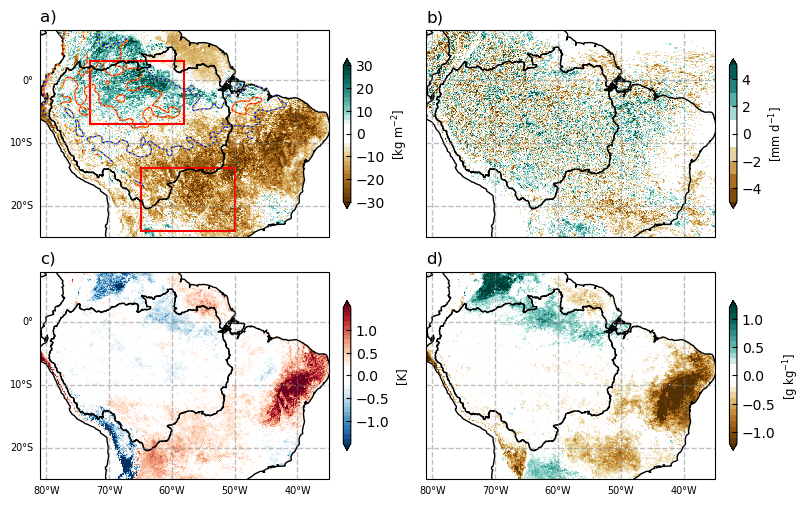

In [11]:
# del(rect1, rect2)
rect1, rect2= add_rectanlgles()
fig = plt.figure(figsize=(8,5),layout='constrained'); xf=-35;xi=-81; yi=-25;yf=8; xl=[-84,-80,-70,-60,-50,-40,-30] ;
ax2 = plt.subplot(221, projection=ccrs.PlateCarree())
cb1 = (sm_control_mean - sm_fixedSM_mean).plot(
    ax=ax2,levels=np.arange(-30,32,2), cmap=to_plot.brownTOwhiteTOgreen, add_colorbar = False, rasterized=True);
sm_mcm.where((sm_mcm>4.9)&(frland.fr_land>0)&(topo5km.topography_c<500)).plot.contour(levels=[6],colors=['b'],linewidths=.8,ax=ax2)
sm_fcm.where((sm_fcm>4.9)&(frland.fr_land>0)&(topo5km.topography_c<500)).plot.contour(levels=[6],colors=['y'],linewidths=1.2,linestyles=':',ax=ax2)

sm_mcm.where((sm_mcm>4.9)&(frland.fr_land>0)&(topo5km.topography_c<500)).plot.contour(levels=[8],colors=['r'],linewidths=.8,ax=ax2)
sm_fcm.where((sm_fcm>4.9)&(frland.fr_land>0)&(topo5km.topography_c<500)).plot.contour(levels=[8],colors=['orange'],linewidths=1.2,linestyles=':',ax=ax2)
ax2.add_patch(rect1); ax2.add_patch(rect2);
ax2.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); to_plot.map_style(
    ax2,xlimi=xi,xlimf=xf,ylimi=yi,ylimf=yf,title1='a)',xloc=xl,sz=7,xb=False); 
cbar = plt.colorbar(cb1, shrink=.7,ticks= np.arange(-30,40,10)); cbar.ax.tick_params(direction='in',labelsize=10); cbar.set_label(label='[kg m$^{-2}$]', size='small');
# cbar = plt.colorbar(cb, shrink=.7); cbar.ax.tick_params(direction='in',labelsize=10); cbar.set_label(label='[kg m$^{-2}$]', size='small');

ax2 = plt.subplot(222, projection=ccrs.PlateCarree())
cb = (deaccu_control_daymean - deaccu_fixedSM_daymean).plot(
    ax=ax2,levels=np.arange(-5,6,1), cmap=to_plot.brownTOwhiteTOgreen, add_colorbar = False, rasterized=True);
ax2.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); to_plot.map_style(
    ax2,xlimi=xi,xlimf=xf,ylimi=yi,ylimf=yf,title1='b)',xloc=xl,yl=False,sz=7,xb=False); 
cbar = plt.colorbar(cb, shrink=.7 ); cbar.ax.tick_params(direction='in',labelsize=10); cbar.set_label(label='[mm d$^{-1}$]', size='small');

ax2 = plt.subplot(223, projection=ccrs.PlateCarree())
cb = (sfc_control_mean.t_g - sfc_fixedSM_mean.t_g).where(frland.fr_land>0).plot(
    ax=ax2,levels=np.arange(-1.5,1.6,.1), cmap=to_plot.blueTOwhiteTOred, add_colorbar = False, rasterized=True);
ax2.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); to_plot.map_style(
    ax2,xlimi=xi,xlimf=xf,ylimi=yi,ylimf=yf,title1='c)',xloc=xl,sz=7); 
cbar = plt.colorbar(cb, shrink=.7,ticks= np.arange(-1,1.5,.5)); cbar.ax.tick_params(direction='in',labelsize=10); cbar.set_label(label='[K]', size='small');

ax2 = plt.subplot(224, projection=ccrs.PlateCarree())
cb = (1e3*sfc_control_mean.qv_s - 1e3*sfc_fixedSM_mean.qv_s).where(frland.fr_land>0).plot(
    ax=ax2,levels=np.arange(-1.2,1.3,.1), cmap=to_plot.brownTOwhiteTOgreen, add_colorbar = False, rasterized=True);
ax2.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); to_plot.map_style(
    ax2,xlimi=xi,xlimf=xf,ylimi=yi,ylimf=yf,title1='d)',xloc=xl,yl=False,sz=7); 
cbar = plt.colorbar(cb, shrink=.7,ticks= np.arange(-1,1.5,.5)); 
cbar.set_label(label='[g kg$^{-1}$]', size='small'); cbar.ax.tick_params(direction='in',labelsize=10); 

# plt.savefig(outplot+"fig1_meanvars_updated.pdf", format="pdf",dpi=300,  bbox_inches="tight")